In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath('../'))
import fastnc

## Halofit Bispectrum class

In [3]:
# Instantiate bispectrum class
bs = fastnc.bispectrum.BispectrumHalofit()

In [4]:
# Assigning linear power spectrum and its growth rate
k, pklin = np.loadtxt('./pklin.dat', unpack=True)
z, lgr   = np.loadtxt('./lgr.dat', unpack=True)
bs.set_pklin(k, pklin)
bs.set_lgr(z, lgr)

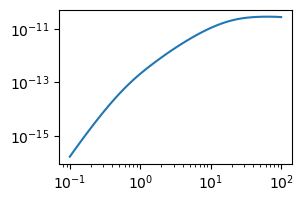

In [5]:
# Compute kappa bispectrum directly
l = np.logspace(-1, 2, 100)
bl= bs.kappa_bispectrum(l,l,l, method='direct')
plt.figure(figsize=(3,2))
plt.loglog(l, l**2*bl);

CPU times: user 1.23 s, sys: 195 ms, total: 1.42 s
Wall time: 1.52 s


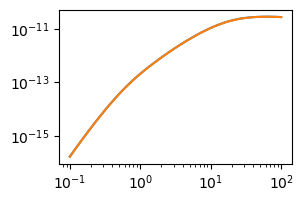

In [6]:
# Interpolation call of kappa bispectrum
%time bs.interpolate()
bli= bs.kappa_bispectrum(l,l,l, method='interp')
plt.figure(figsize=(3,2))
plt.loglog(l, l**2*bl)
plt.loglog(l, l**2*bli);

[multipole]: 100%|██████████| 16/16 [00:01<00:00, 15.64it/s, L=15]


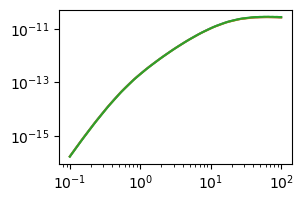

In [7]:
# decompose into multipoles up to a specified maximum multipole, Lmax.
bs.decompose(15, method_bispec='interp')
blr= bs.kappa_bispectrum(l,l,l, method='resum')
plt.figure(figsize=(3,2))
plt.loglog(l, l**2*bl)
plt.loglog(l, l**2*bli)
plt.loglog(l, l**2*blr);

# Fastnc class: Fast Natural Component

In [8]:
# Instantiate fast natural components class with Lmax=15, Lmin=30
# This can be slow for the first time to create GLM cache.
nc = fastnc.fastnc.FastNaturalComponents(15, 30)

Load GLMdata from cache: GLMdata-2.pkl


[GLM]: 100%|██████████| 496/496 [00:00<00:00, 770.81it/s, L=15, M=30]


In [9]:
# Set bispectrum
# Note: you need to interpolate bispectrum before setting it to fastnc
# Note: you *do not* have to decompose bispectrum, fastnc calls `decompose` internally.
nc.set_bispectrum(bs)

[multipole]: 100%|██████████| 16/16 [00:01<00:00, 10.48it/s, L=15]


In [10]:
# compute fastnc kernel, FM, for a given natural component index=0, i.e. prep. for Gamma^{(0)}.
nc.compute_FM(0)

[kernel]: 100%|██████████| 31/31 [00:02<00:00, 10.83it/s, M=30]


CPU times: user 11.3 ms, sys: 2 ms, total: 13.3 ms
Wall time: 11.8 ms


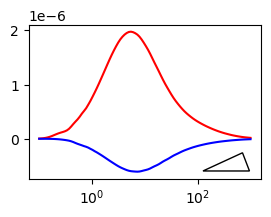

In [11]:
# Compute Gamma^{(0)} with x-projection with treecorr convention
t = np.logspace(-1, 3, 100) # arcmin
r = np.deg2rad(t/60.0) # rad
u = 0.45
v = 0.15
%time g0 = nc.Gamma0_treecorr(r, u, v)
fig, ax = plt.subplots(1,1,figsize=(3,2))
ax.semilogx(t, t*g0.real, color='red' , label='real')
ax.semilogx(t, t*g0.imag, color='blue', label='imag');
x1,x2,x3=fastnc.trigutils.ruv_to_x1x2x3(1,u,v)
fastnc.devtool.plot_triangle(ax, x1,x2,x3)


CPU times: user 11.2 ms, sys: 1.65 ms, total: 12.8 ms
Wall time: 11.3 ms


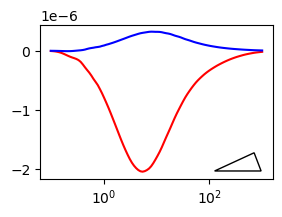

In [12]:
# Same but centroid-projection
t = np.logspace(-1, 3, 100) # arcmin
r = np.deg2rad(t/60.0) # rad
u = 0.45
v = 0.15
%time g0 = nc.Gamma0_treecorr(r, u, v, projection='cent')
fig, ax = plt.subplots(1,1,figsize=(3,2))
ax.semilogx(t, t*g0.real, color='red' , label='real')
ax.semilogx(t, t*g0.imag, color='blue', label='imag');
x1,x2,x3=fastnc.trigutils.ruv_to_x1x2x3(1,u,v)
fastnc.devtool.plot_triangle(ax, x1,x2,x3)

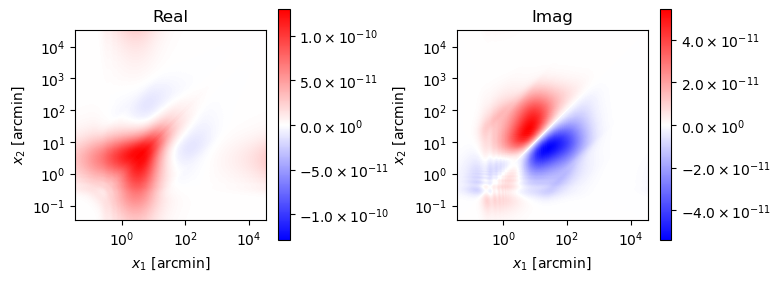

In [13]:
# plot the structure of natural component Gamma^{(0)} in two dimensional space 
# with a fixed outer angle, dvphi between x1 and x2
# This is plotting Gamma^{(0)}(x1, x2, dvphi)(x1x2)^{1/2} on (x1, x2) grids.
dvphi = np.pi/3
g0 = nc.Gamma0(dvphi)
x1, x2 = nc.x1, nc.x2
fig, ax = fastnc.devtool.imshow_g0(x1, x2, g0)

# Speed of fastnc

In [14]:
# define bin
t = np.logspace(-1, 3, 100) # arcmin
r = np.deg2rad(t/60.0) # rad
ubins = [0.16, 0.35, 0.55, 0.75, 0.95]
vbins = [0.15, 0.35, 0.55, 0.75, 0.97]

In [15]:
# Measure the time of fastnc computation
# which is done every mcmc step.
sw = fastnc.devtool.StopWatch()

bs.interpolate(); sw('interp')
nc.set_bispectrum(bs); sw('multipole')
nc.compute_FM(0); sw('kernel')

g0 = [[0 for _ in range(5)] for _ in range(5)]
for i, u in enumerate(ubins):
    for j, v in enumerate(vbins):
        g0[i][j] = nc.Gamma0_treecorr(r, u, v, projection='cent')
sw('Gamma0')
sw.close()

interp: 1.510s


[multipole]: 100%|██████████| 16/16 [00:01<00:00, 15.36it/s, L=15]


multipole: 1.622s


[kernel]: 100%|██████████| 31/31 [00:02<00:00, 12.03it/s, M=30]


kernel: 2.584s
Gamma0: 0.241s
Total: 5.956s


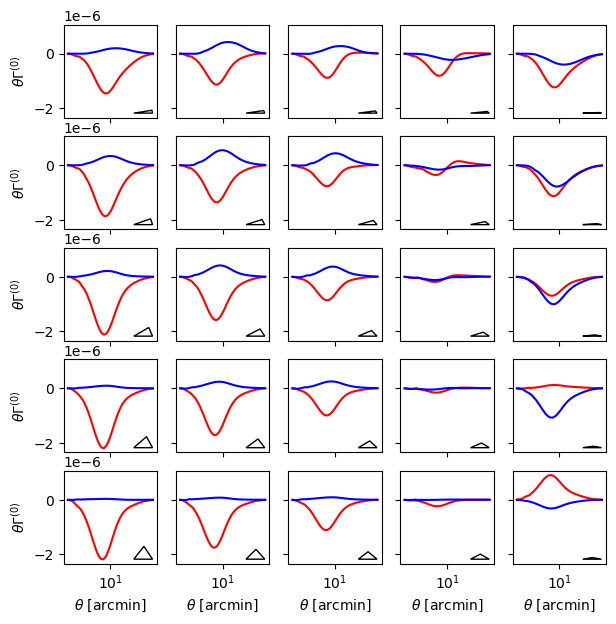

In [16]:
fig, axes = plt.subplots(5,5,figsize=(7,7), sharex=True, sharey=True)
for i, u in enumerate(ubins):
    for j, v in enumerate(vbins):
        ax = axes[i,j]
        ax.set_xscale('log')
        ax.semilogx(t, t*g0[i][j].real, color='red')
        ax.semilogx(t, t*g0[i][j].imag, color='blue')
        x1,x2,x3=fastnc.trigutils.ruv_to_x1x2x3(1,u,v)
        fastnc.devtool.plot_triangle(ax,x1,x2,x3)
        ax.set_xlabel(r'$\theta$ [arcmin]') if i==4 else None
        ax.set_ylabel(r'$\theta\Gamma^{(0)}$') if j==0 else None
plt.show()

## Comparison of 1halo and 3halo contributions

In [19]:
def temp(which):
    bs.interpolate(which=which)
    nc.set_bispectrum(bs)
    nc.compute_FM(0)

    g0 = [[0 for _ in range(5)] for _ in range(5)]
    for i, u in enumerate(ubins):
        for j, v in enumerate(vbins):
            g0[i][j] = nc.Gamma0_treecorr(r, u, v, projection='cent')

    return g0

g0_h1 = temp('Bh1')
g0_h3 = temp('Bh3')
g0_tot = temp(['Bh1', 'Bh3'])

[kernel]: 100%|██████████| 31/31 [00:03<00:00,  9.86it/s, M=30]


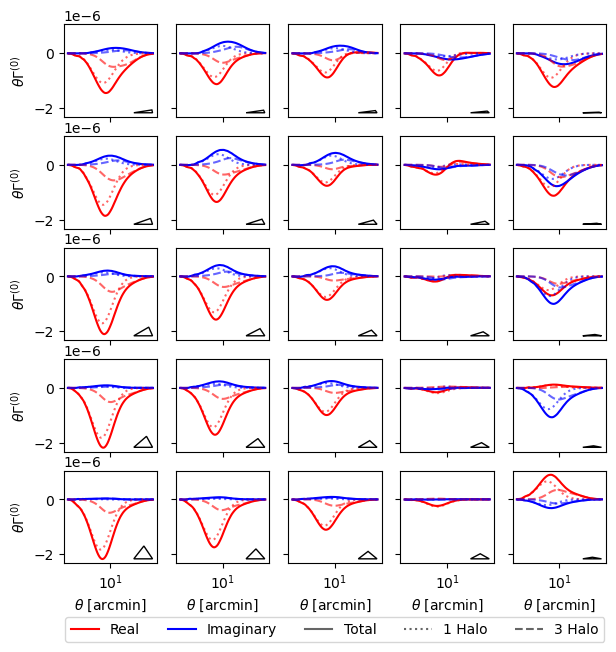

In [20]:
fig, axes = plt.subplots(5,5,figsize=(7,7), sharex=True, sharey=True)
for i, u in enumerate(ubins):
    for j, v in enumerate(vbins):
        ax = axes[i,j]
        ax.set_xscale('log')
        ax.semilogx(t, t*g0_tot[i][j].real, color='red')
        ax.semilogx(t, t*g0_tot[i][j].imag, color='blue')
        ax.semilogx(t, t*g0_h1[i][j].real, color='red', ls=':', alpha=0.6)
        ax.semilogx(t, t*g0_h1[i][j].imag, color='blue', ls=':', alpha=0.6)
        ax.semilogx(t, t*g0_h3[i][j].real, color='red', ls='--', alpha=0.6)
        ax.semilogx(t, t*g0_h3[i][j].imag, color='blue', ls='--', alpha=0.6)
        x1,x2,x3=fastnc.trigutils.ruv_to_x1x2x3(1,u,v)
        fastnc.devtool.plot_triangle(ax,x1,x2,x3)
        ax.set_xlabel(r'$\theta$ [arcmin]') if i==4 else None
        ax.set_ylabel(r'$\theta\Gamma^{(0)}$') if j==0 else None

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linestyle='-', label='Real'),
    Line2D([0], [0], color='blue', linestyle='-', label='Imaginary'),
    Line2D([0], [0], color='black', linestyle='-', alpha=0.6, label='Total'),
    Line2D([0], [0], color='black', linestyle=':', alpha=0.6, label='1 Halo'),
    Line2D([0], [0], color='black', linestyle='--', alpha=0.6, label='3 Halo')
]
axes[4, 2].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.5), ncols=5)

plt.show()